In [18]:
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [19]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root = '../data', train=True, download=True,transform=transform)
test_data = datasets.MNIST(root='../data',train=False, download=True, transform=transform)

In [25]:
batch_size = 20
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

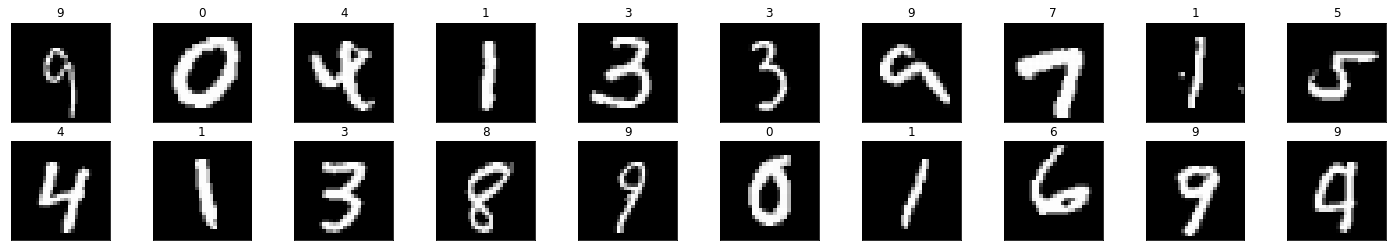

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
   
    def __init__(self):
        super(Net,self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(784, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self , x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = Net()

In [28]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [32]:
epochs=30
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf


for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
        
    for data,target in valid_loader:
        output = model(data)
        loss = criterion(output,target)
        valid_loss += loss.item()*data.size(0)
        
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    print('epoch : {} \t Training Loss : {:.6f}\t Validation Loss : {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

epoch : 1 	 Training Loss : 0.491791	 Validation Loss : 0.514318
Validation loss decreased (inf --> 0.514318).  Saving model ...


KeyboardInterrupt: 

In [ ]:
test_loss = 0.0
class_correct = list(0, for i in range(10))
class_total = list(0, for i in range(10))

model.eval()

for data,target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    #convert output prob to predicted class
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label =target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))